# GrayBox Evasion Attack

In [1]:
import torch
from PIL import Image
from IPython import display

import pandas as pd
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


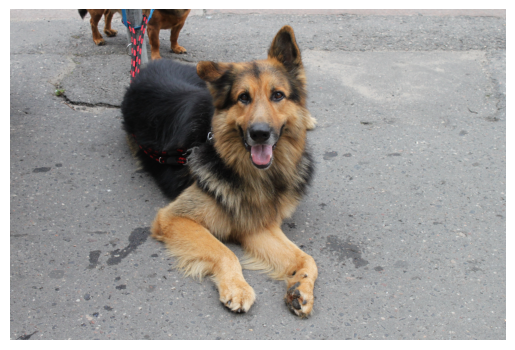

Image tensor on device:
---------------
cpu

Inputs information:
---------------
shape:torch.Size([1, 3, 224, 224])
class: <class 'torch.Tensor'>

Shape of outputs:
---------------
torch.Size([1, 1000])

Pred Index:
---------------
235

Pred Label:
---------------
German shepherd



In [4]:
#load the model from the pytorch hub
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights='MobileNet_V2_Weights.DEFAULT', verbose=False)

# Put model in evaluation mode
model.eval()

# put the model on a GPU if available, otherwise CPU
model.to(device);

# Define the transforms for preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),  # Resize the image to 256x256
    transforms.CenterCrop(224),  # Crop the image to 224x224 about the center
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalize the image with the ImageNet dataset mean values
        std=[0.229, 0.224, 0.225]  # Normalize the image with the ImageNet dataset standard deviation values
    )
]);

unnormalize = transforms.Normalize(
   mean= [-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
   std= [1/s for s in [0.229, 0.224, 0.225]]
)

with open("../data/labels.txt", 'r') as f:
    labels = [label.strip() for label in f.readlines()]

img = Image.open("../data/dog.jpg")

plt.imshow(img)
plt.axis('off')
plt.show()

img_tensor = preprocess(img).unsqueeze(0)
img_tensor = img_tensor.to(device)

with torch.no_grad():
    output = model(img_tensor)

print(f"Image tensor on device:\n---------------\n{img_tensor.device}\n")
print(f"Inputs information:\n---------------\nshape:{img_tensor.shape}\nclass: {type(img_tensor)}\n")
print(f"Shape of outputs:\n---------------\n{output.shape}\n")
print(f"Pred Index:\n---------------\n{output[0].argmax()}\n")
print(f"Pred Label:\n---------------\n{labels[output[0].argmax()]}\n")

unnormed_img_tensor= unnormalize(img_tensor)


## SimBA or Simple BlackBox Attack

In [5]:
# create new img_tensor
img_tensor = preprocess(img).unsqueeze(0).to(device)

### Generate random masks

In [6]:
n_masks = 1000
eta = 0.005

mask_collection = torch.randn((n_masks, *img_tensor.shape)).to(device)*eta

current_mask = torch.zeros_like(img_tensor).to(device)

In [7]:
# compute our starting index
starting_index = model(img_tensor).argmax(1)
print(f"Starting index is:\n---------------\n{starting_index}\n")

starting_class_score = model(img_tensor + current_mask)[0, starting_index.item()].item()
print(f"Starting class score is:\n---------------\n{starting_class_score}\n")

Starting index is:
---------------
tensor([235])

Starting class score is:
---------------
5.693295955657959



### Run the untargeted attack

In [9]:
# Zero our current mask
current_mask = torch.zeros_like(img_tensor).to(device)

# Get our starting label index
starting_label = model(img_tensor).argmax(1)
current_label = starting_label

# Get our starting confidence score
best_score = model(img_tensor + current_mask)[0, starting_index.item()].item()

# Run until we reclassify successfully ...
while current_label == starting_label:

    # Select a random mask from the collection we created
    mask_candidate_idx = np.random.choice(len(mask_collection))
    mask_candidate = mask_collection[mask_candidate_idx]

    # Don't store gradient information while doing inference
    with torch.no_grad():
        # get the scores for the image if we updated the current mask to
        # use the candidate we just randomly picked
        output = model(img_tensor + current_mask + mask_candidate)
    
    # select the most probable label from the output of the model with the candidate mask in play
    current_label = output.argmax(1).item()
    # our score will be the score of our original label: we want this to go _down_ (i.e. the current
    # label to become less likely)
    new_score = output[0, starting_label.item()].item()

    # If the score for the current class -- the one we're trying to get away from -- did not decrease, then
    # skip back to the beginning and pick another candidate mask
    if new_score >= best_score:
        continue

    # If we got to here, then we decreased the score of the true class for the image; this means
    # the score for some other class went up, and at some point if we get the score for the true 
    # label low enough, some other class will be the maximum and we will have successfully misclassified.
    
    
    # Write some monitoring for dopamine 
    print(f"Best score is: {best_score:4.6f} -- prediction is: {current_label}  ", end='\r', flush=True)
    
    # Update our current score
    best_score = new_score
    
    # And update our mask
    current_mask += mask_candidate
                
print(f"\n\nWinner winner: {labels[output[0].argmax()]} ({output[0].argmax()})")

Best score is: 3.691486 -- prediction is: 260  

Winner winner: chow (260)


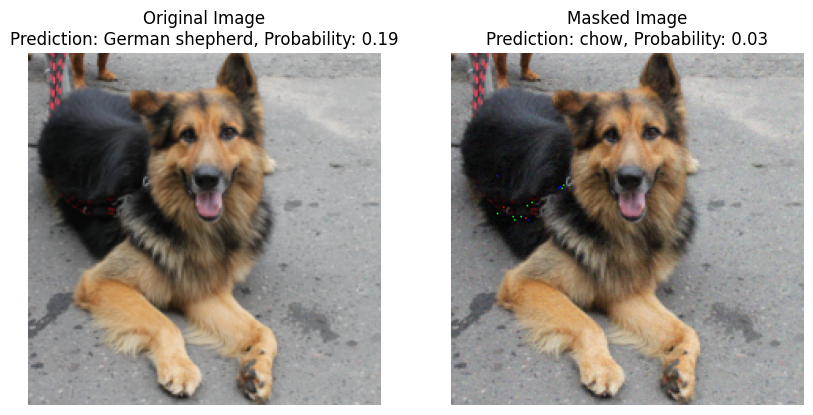

In [10]:
with torch.no_grad():
    output = model(img_tensor)
    masked = model(img_tensor + current_mask)
    
    probs = torch.softmax(output, dim=1)[0][output[0].argmax()].item()
    mask_probs = torch.softmax(masked, dim=1)[0][masked[0].argmax()].item()

    prediction = labels[output[0].argmax()]
    mask_prediction = labels[masked[0].argmax()]

    unnormed_img_tensor= unnormalize(img_tensor)
    unnormed_mask_tensor= unnormalize(img_tensor + current_mask)

    img_pil = transforms.functional.to_pil_image(unnormed_img_tensor[0])
    masked_pil = transforms.functional.to_pil_image(unnormed_mask_tensor[0])
    
plt.figure(figsize=(10, 5))  # Adjust the figsize as needed
plt.subplot(1, 2, 1)
plt.imshow(img_pil)
plt.title(f"Original Image\nPrediction: {prediction}, Probability: {probs:.2f}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masked_pil)
plt.title(f"Masked Image\nPrediction: {mask_prediction}, Probability: {mask_probs:.2f}")
plt.axis('off')

plt.show()

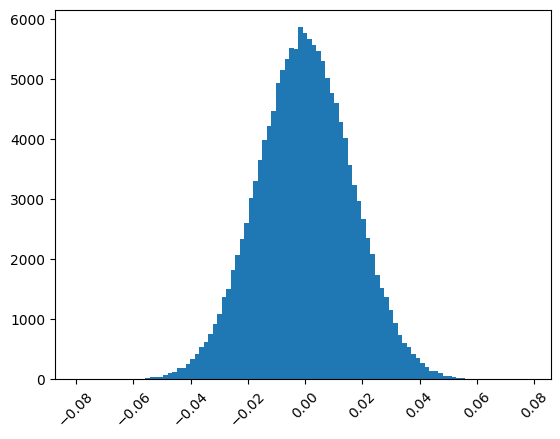

Minimum and maximum difference between the images: -0.07956531643867493 0.07797965407371521


In [11]:
difference = unnormed_mask_tensor - unnormed_img_tensor
difference_list = difference.view(-1).tolist()

# Plot the histogram
plt.hist(difference_list, bins=100)
plt.xticks(rotation=45)
plt.show()

print("Minimum and maximum difference between the images:", difference.min().item(), difference.max().item())

## Targeted attack

In [14]:
target_index = torch.tensor(labels.index('tiger')).unsqueeze(0).to(device)
print(f"Target index is:\n---------------\n{target_index}\n")

target_class_score = model(img_tensor + current_mask)[0, target_index.item()].item()
print(f"Target class score is:\n---------------\n{target_class_score}\n")

Target index is:
---------------
tensor([292])

Target class score is:
---------------
4.488437175750732



In [20]:
# Zero our current mask
current_mask = torch.zeros_like(img_tensor).to(device)

# Get our starting label index
starting_label = model(img_tensor).argmax(1).item()
current_label = starting_label

# Target class index
target_index = torch.tensor(labels.index('tiger')).unsqueeze(0).to(device)

# Get our starting confidence score
best_score = model(img_tensor + current_mask)[0, target_index.item()].item()

# Run until we reclassify successfully ...
while current_label != target_index:

    # Select a random mask from the collection we created
    mask_candidate_idx = np.random.choice(len(mask_collection))
    mask_candidate = mask_collection[mask_candidate_idx]

    # Don't store gradient information while doing inference
    with torch.no_grad():
        output = model(img_tensor + current_mask + mask_candidate)
    
    # Based on our mask addition, get our new label and updated score
    current_label = output.argmax(1).item()
    new_score = output[0, target_index.item()].item()

    # If we haven't hit our target yet and also didn't improve the score, just move on
    # NOTE CHANGED TARGET_LABEL TO STARTING_LABEL because our goal is to NOT BE what we are more than be a specific thing
    if new_score < best_score:
        continue

    # Write some monitoring for dopamine 
    print(f"Best score is: {best_score:4.6f} -- pred score is: {output[0, current_label].item()} -- prediction is: {current_label}  ", end='\r', flush=True)
    
    # Update our current score
    best_score = new_score
    
    # And update our mask
    current_mask += mask_candidate
                
print(f"\n\nWinner winner: {labels[output[0].argmax()]}")

Best score is: 5.756288 -- pred score is: 5.76174783706665 -- prediction is: 292    

Winner winner: tiger


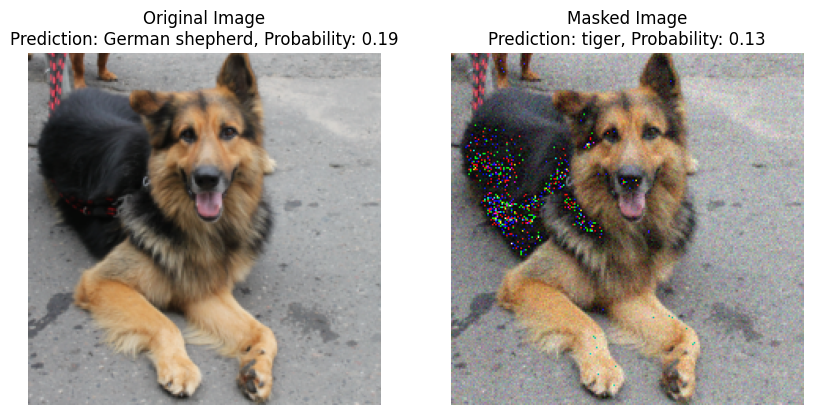

In [26]:
with torch.no_grad():
    output = model(img_tensor)
    masked = model(img_tensor + current_mask)
    
    probs = torch.softmax(output, dim=1)[0][output[0].argmax()].item()
    mask_probs = torch.softmax(masked, dim=1)[0][masked[0].argmax()].item()

    prediction = labels[output[0].argmax()]
    mask_prediction = labels[masked[0].argmax()]

    unnormed_img_tensor= unnormalize(img_tensor)
    unnormed_mask_tensor= unnormalize(img_tensor + current_mask)

    img_pil = transforms.functional.to_pil_image(unnormed_img_tensor[0])
    masked_pil = transforms.functional.to_pil_image(unnormed_mask_tensor[0])
    
plt.figure(figsize=(10, 5))  # Adjust the figsize as needed
plt.subplot(1, 2, 1)
plt.imshow(img_pil)
plt.title(f"Original Image\nPrediction: {prediction}, Probability: {probs:.2f}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masked_pil)
plt.title(f"Masked Image\nPrediction: {mask_prediction}, Probability: {mask_probs:.2f}")
plt.axis('off')

plt.show()